# Imports

In [592]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [604]:
import os
from tqdm import tqdm
import pandas as pd

import selfies as sf
from rdkit import Chem
from rdkit.Chem import Descriptors

import torch
import torch.nn.functional as F

from src.selfies import SelfiesEncoder
from src.vae import MolecularVAE

In [605]:
import seaborn as sns
import matplotlib.pyplot as plt

sns.set(palette='colorblind', font_scale=1.3)
palette = sns.color_palette()

# Preprocessing

In [6]:
data_path = "data"

Download raw dataset:

In [7]:
dataset_url = "https://deepchemdata.s3-us-west-1.amazonaws.com/datasets/qm9.csv"

raw_df = pd.read_csv(dataset_url)
raw_df.to_csv(os.path.join(data_path, "qm9_raw.csv"), index=False)

Add selfies encoding to raw data:

In [20]:
def compute_logp(smile):
    mol = Chem.MolFromSmiles(smile)
    return Descriptors.MolLogP(mol)

In [23]:
df = pd.read_csv(os.path.join(data_path, "qm9_raw.csv"))
df = df[["mol_id", "smiles", "mu", "alpha", "homo", "lumo", "gap", "r2"]]

df["selfies"] = [sf.encoder(x, strict=False) for x in raw_df.smiles]
df["logp"] = [compute_logp(s) for s in raw_df.smiles]

df.to_csv(os.path.join(data_path, "qm9_processed.csv"), index=False)

Generate one-hot enocding for selfies strings:

In [384]:
df = pd.read_csv(os.path.join(data_path, "qm9_processed.csv"))
df.head()

,mol_id,smiles,mu,alpha,homo,lumo,gap,r2,selfies,logp
0,gdb_1,C,0.0000,13.21,-0.3877,0.1171,0.5048,35.3641,[C],0.63610
1,gdb_2,N,1.6256,9.46,-0.2570,0.0829,0.3399,26.1563,[N],0.16200
2,gdb_3,O,1.8511,6.31,-0.2928,0.0687,0.3615,19.0002,[O],-0.82470
3,gdb_4,C#C,0.0000,16.28,-0.2845,0.0506,0.3351,59.5248,[C][#C],0.24940
4,gdb_5,C#N,2.8937,12.99,-0.3604,0.0191,0.3796,48.7476,[C][#N],0.13978


In [393]:
selfies = df.selfies

selfies_encoder = SelfiesEncoder.build(selfies)

In [394]:
one_hots = []
for s in tqdm(selfies):
    one_hots.append(selfies_encoder.encode_one_hot(s))
one_hots = torch.tensor(one_hots)
torch.save(one_hots, os.path.join(data_path, "qm9_encodings.pt"))

100%|██████████████████████████████████████████████████████████████████████████████████████████| 133885/133885 [00:03<00:00, 35364.85it/s]


# VAE

## Methods

In [427]:
def vae_loss(x, x_recon, z_mean, z_logvar):
    bce = F.binary_cross_entropy(x_recon, x, reduction="sum")
    kld = -0.5 * torch.sum(1 + z_logvar - z_mean.pow(2) - z_logvar.exp())
    return bce + kld

def train_one_epoch(model, optimizer, scheduler, train_loader):
    model.train()

    total_loss = 0.0
    for batch in train_loader:
        x = batch[0]

        optimizer.zero_grad()
        x_recon, z_mean, z_logvar = model(x)
        loss = vae_loss(x, x_recon, z_mean, z_logvar)
        loss.backward()
        optimizer.step()

        total_loss += loss.item()

    if scheduler is not None:
        scheduler.step()

    return total_loss / len(train_loader.dataset)

@torch.no_grad()
def test_one_epoch(model, test_loader):
    model.eval()

    total_loss = 0.0
    for batch in test_loader:
        x = batch[0]
        x_recon, z_mean, z_logvar = model(x)
        loss = vae_loss(x, x_recon, z_mean, z_logvar)
        total_loss += loss.item()

    return total_loss / len(test_loader.dataset)

def train(model, optimizer, train_loader, test_loader, n_epochs, scheduler=None, print_every=10):    
    train_losses, test_losses = [], []
    for epoch in range(n_epochs):
        train_loss_epoch = train_one_epoch(model, optimizer, scheduler, train_loader)
        train_losses.append(train_loss_epoch)

        test_loss_epoch = test_one_epoch(model, train_loader)
        test_losses.append(test_loss_epoch)

        if epoch == 0 or (epoch + 1) % print_every == 0:
            print(f"Epoch {epoch+1} | Train Loss = {train_loss_epoch:.4f} | Test loss = {test_loss_epoch:.4f}")
    
    return train_losses, test_losses

## Training

In [606]:
torch.manual_seed(42)
device = device = 'cuda' if torch.cuda.is_available() else 'cpu'

x = torch.load(os.path.join(data_path, "qm9_encodings.pt"))
x = x.float().to(device)
full_dataset =  torch.utils.data.TensorDataset(x)

test_frac = 0.1
test_size = int(test_frac * len(x))
train_size = len(x) - test_size

train_dataset, test_dataset = torch.utils.data.random_split(full_dataset, [train_size, test_size])

In [607]:
batch_size = 250

train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size, shuffle=True)

In [631]:
model = MolecularVAE(
    input_size=x.size(1), 
    input_channels=x.size(2),
    conv_kernels=[8, 8, 5],
    encoder_hidden_size=100,
    gru_hidden_size=200,
)
print(model.n_parameters())
model.to(device)
model

935137


MolecularVAE(
  (encoder_conv): Sequential(
    (0): Conv1d(29, 9, kernel_size=(8,), stride=(1,))
    (1): ReLU()
    (2): Conv1d(9, 9, kernel_size=(8,), stride=(1,))
    (3): ReLU()
    (4): Conv1d(9, 9, kernel_size=(5,), stride=(1,))
    (5): ReLU()
  )
  (encoder_linear): Sequential(
    (0): Linear(in_features=27, out_features=100, bias=True)
    (1): SELU()
  )
  (encoder_mean): Linear(in_features=100, out_features=292, bias=True)
  (encoder_logvar): Linear(in_features=100, out_features=292, bias=True)
  (decoder_linear): Sequential(
    (0): Linear(in_features=292, out_features=292, bias=True)
    (1): SELU()
  )
  (decoder_gru): GRU(292, 200, num_layers=3, batch_first=True)
  (decoder_output): Sequential(
    (0): Linear(in_features=200, out_features=29, bias=True)
    (1): Softmax(dim=1)
  )
)

In [625]:
list((1,))[1:]

[]

In [621]:
model(x[:5])

RuntimeError: Given groups=1, weight of size [9, 29, 10], expected input[5, 9, 11] to have 29 channels, but got 9 channels instead

In [616]:
learning_rate = 1e-3
weight_decay = 1e-5

optimizer = torch.optim.Adam(
    model.parameters(), 
    lr=learning_rate, 
    weight_decay=weight_decay,
)

In [617]:
n_epochs = 50
train_losses, test_losses = train(
    model, 
    optimizer, 
    train_loader, 
    test_loader, 
    n_epochs=n_epochs,
    print_every=1
)

RuntimeError: Given groups=1, weight of size [9, 29, 10], expected input[250, 9, 11] to have 29 channels, but got 9 channels instead

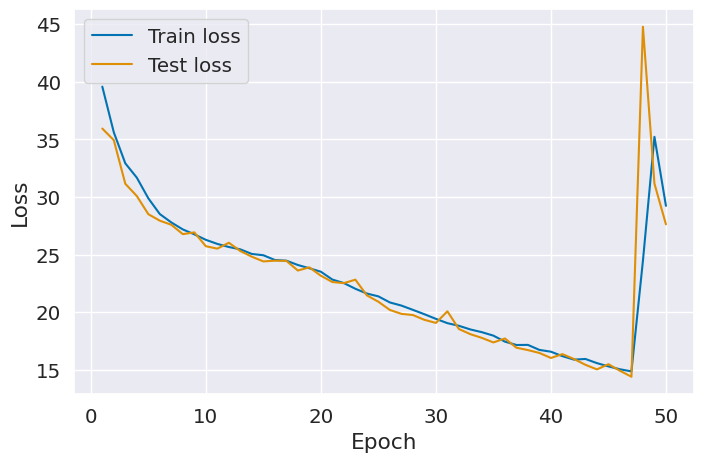

In [587]:
_, ax = plt.subplots(1, 1, figsize=(8, 5))
ax.plot(range(1, n_epochs + 1), train_losses, label='Train loss')
ax.plot(range(1, n_epochs + 1), test_losses, label='Test loss')
ax.set_xlabel('Epoch')
ax.set_ylabel('Loss')
ax.legend()

plt.show()

In [588]:
selfies_encoder.decode_tensor(x[:10])

['[C][nop][nop][nop][nop][nop][nop][nop][nop][nop][nop][nop][nop][nop][nop][nop][nop][nop][nop][nop][nop]',
 '[N][nop][nop][nop][nop][nop][nop][nop][nop][nop][nop][nop][nop][nop][nop][nop][nop][nop][nop][nop][nop]',
 '[O][nop][nop][nop][nop][nop][nop][nop][nop][nop][nop][nop][nop][nop][nop][nop][nop][nop][nop][nop][nop]',
 '[C][#C][nop][nop][nop][nop][nop][nop][nop][nop][nop][nop][nop][nop][nop][nop][nop][nop][nop][nop][nop]',
 '[C][#N][nop][nop][nop][nop][nop][nop][nop][nop][nop][nop][nop][nop][nop][nop][nop][nop][nop][nop][nop]',
 '[C][=O][nop][nop][nop][nop][nop][nop][nop][nop][nop][nop][nop][nop][nop][nop][nop][nop][nop][nop][nop]',
 '[C][C][nop][nop][nop][nop][nop][nop][nop][nop][nop][nop][nop][nop][nop][nop][nop][nop][nop][nop][nop]',
 '[C][O][nop][nop][nop][nop][nop][nop][nop][nop][nop][nop][nop][nop][nop][nop][nop][nop][nop][nop][nop]',
 '[C][C][#C][nop][nop][nop][nop][nop][nop][nop][nop][nop][nop][nop][nop][nop][nop][nop][nop][nop][nop]',
 '[C][C][#N][nop][nop][nop][nop][nop][

In [589]:
x_recon, _, _ = model(x[:10])

selfies_encoder.decode_tensor(x_recon)

['[C][C][C][C][nop][nop][nop][nop][nop][nop][nop][nop][nop][nop][nop][nop][nop][nop][nop][nop][nop]',
 '[C][C][C][C][nop][nop][nop][nop][nop][nop][nop][nop][nop][nop][nop][nop][nop][nop][nop][nop][nop]',
 '[C][C][C][C][nop][nop][nop][nop][nop][nop][nop][nop][nop][nop][nop][nop][nop][nop][nop][nop][nop]',
 '[C][C][C][C][nop][nop][nop][nop][nop][nop][nop][nop][nop][nop][nop][nop][nop][nop][nop][nop][nop]',
 '[C][C][C][C][nop][nop][nop][nop][nop][nop][nop][nop][nop][nop][nop][nop][nop][nop][nop][nop][nop]',
 '[C][C][C][C][nop][nop][nop][nop][nop][nop][nop][nop][nop][nop][nop][nop][nop][nop][nop][nop][nop]',
 '[C][C][C][C][nop][nop][nop][nop][nop][nop][nop][nop][nop][nop][nop][nop][nop][nop][nop][nop][nop]',
 '[C][C][C][C][nop][nop][nop][nop][nop][nop][nop][nop][nop][nop][nop][nop][nop][nop][nop][nop][nop]',
 '[C][C][C][C][nop][nop][nop][nop][nop][nop][nop][nop][nop][nop][nop][nop][nop][nop][nop][nop][nop]',
 '[C][C][C][C][nop][nop][nop][nop][nop][nop][nop][nop][nop][nop][nop][nop][nop][no

# Flory

In [5]:
n_components = 2
objective = FloryHuggins(n_components)
objective.set_size(0, 1)
objective.set_pairwise(0, 1, 3.0)

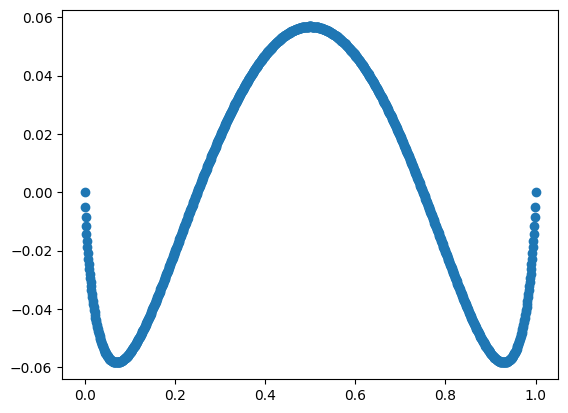

In [6]:
n = 1000

x0 = torch.linspace(0.0, 1.0, n)
x1 = 1.0 - x0

x = torch.stack([x0, x1], dim=1)
y = objective(x)

plt.scatter(x[:,1], y)
plt.show()